In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Convolutional Neural Network

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time

In [5]:
from sklearn.metrics import multilabel_confusion_matrix
def accuracy_per_class(y_true, y_pred):
    confusion_matrix = multilabel_confusion_matrix(y_true, np.argmax(y_pred,axis=1), labels=range(10))
    acc_per_class = {'Class':[], 'Accuracy':[]}
    for i in range(confusion_matrix.shape[0]):
        acc_per_class['Class'].append(i)
        acc_per_class['Accuracy'].append(np.trace(confusion_matrix[i])/np.sum(confusion_matrix[i]))
    return acc_per_class


def plot_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [117]:
X_train = np.load('../input/cisc6000-deep-learning-hw2/cifar.train.npy')
y_train = np.load('../input/cisc6000-deep-learning-hw2/cifar.trainlabel.npy')
X_test = np.load('../input/cisc6000-deep-learning-hw2/cifar.test.npy')
y_test = pd.read_csv('../input/cisc6000-deep-learning-hw2/cifar.testlabel.csv')
y_test = y_test["class"].values

In [118]:
X_train = np.rollaxis(X_train,1,4)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.80)

X_train = tf.constant(X_train); y_train = tf.constant(y_train)

X_valid = tf.constant(X_valid); y_valid = tf.constant(y_valid)

X_test = np.rollaxis(X_test,1,4)
X_test = tf.constant(X_test); y_test = tf.constant(np.expand_dims(y_test, axis=1))

2022-11-14 03:17:07.712913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 943718400 exceeds 10% of free system memory.


### A. Validation

In [8]:
a1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64, 64, 16)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same")], name="BaseModel")
a1.summary()

Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        4640      
Total params: 4,640
Trainable params: 4,640
Non-trainable params: 0
_________________________________________________________________


In [9]:
a2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64, 64, 16)),
    tf.keras.layers.Conv2D(filters=5, kernel_size=1, strides=(1,1), padding="same"),
    tf.keras.layers.Conv2D(filters=5, kernel_size=1, strides=(1,1), padding="same"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same")], name="BaseModel")
a2.summary()

Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 5)         85        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 5)         30        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        1472      
Total params: 1,587
Trainable params: 1,587
Non-trainable params: 0
_________________________________________________________________


### B. Implement and train your baseline model Mbase using the following specifications:
* Use 20% of your data for validation
* Your model will have 3 convolutional layers
* Number of filters for the convolutional layers are 16, 32, 48 respectively
* Maxpooling (2 x 2) following the first two convolutional layers
* Two fully connected layers of size 500 and 10 respectively
* Padding = same, kernel size = 3, stride = 1.
* Training: epoch = 80, batch size = 128, learning rate = 0.001, optimizer = Adam, activation = ReLU

1. Present your model’s summary.
2. Save your best (hint: use ModelCheckpoint callback) Mbase in hdf5 format and
plot the learning curve of Mbase.
3. Fill in Row #1 in Table 1.


In [10]:
monitor = "val_loss"
def performance_table(train_perf, val_perf):
    return pd.DataFrame({"Training": train_perf, "Validation": val_perf}, index=["Loss", "Accuracy"])

In [11]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((32, 32, 3)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")], name="BaseModel")
base_model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])
base_model.summary()

Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 48)          13872     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               15

In [126]:
ModelCheckpoint_path = "Q1_base_model_checkpoint.hdf5"
# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path,
                                                      monitor=monitor,
                                                      save_weights_only=True,
                                                      save_best_only=True,)
start = time()
history_base_model = base_model.fit(x=X_train, y=y_train,
                                    epochs=80,
                                    batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint])
base_model_time = time()-start

Epoch 1/80
300/300 [==============================] - 1s 5ms/step - loss: 0.5556 - accuracy: 0.8099 - val_loss: 0.5556 - val_accuracy: 0.8126
Epoch 2/80
300/300 [==============================] - 1s 5ms/step - loss: 0.3860 - accuracy: 0.8699 - val_loss: 0.5988 - val_accuracy: 0.7975
Epoch 3/80
300/300 [==============================] - 1s 5ms/step - loss: 0.2530 - accuracy: 0.9171 - val_loss: 0.6398 - val_accuracy: 0.7987
Epoch 4/80
300/300 [==============================] - 2s 5ms/step - loss: 0.1403 - accuracy: 0.9554 - val_loss: 0.6779 - val_accuracy: 0.8024
Epoch 5/80
300/300 [==============================] - 1s 5ms/step - loss: 0.0942 - accuracy: 0.9709 - val_loss: 0.7420 - val_accuracy: 0.7961
Epoch 6/80
300/300 [==============================] - 1s 5ms/step - loss: 0.0527 - accuracy: 0.9857 - val_loss: 0.8318 - val_accuracy: 0.7952
Epoch 7/80
300/300 [==============================] - 1s 5ms/step - loss: 0.0411 - accuracy: 0.9878 - val_loss: 0.9043 - val_accuracy: 0.7873
Epoch 

In [127]:
base_model.load_weights(ModelCheckpoint_path) #load best model weights
training_performance = base_model.evaluate(X_train, np.squeeze(y_train), verbose=0)
validation_performance = base_model.evaluate(X_valid, np.squeeze(y_valid), verbose=0)
print(performance_table(training_performance, validation_performance))

          Training  Validation
Loss      0.366230    0.555570
Accuracy  0.886484    0.812604


In [128]:
test_predictions = base_model.predict(X_test)
print(pd.DataFrame(accuracy_per_class(np.squeeze(y_test), test_predictions)))

   Class  Accuracy
0      0  0.949667
1      1  0.967000
2      2  0.921000
3      3  0.911167
4      4  0.928583
5      5  0.924000
6      6  0.955333
7      7  0.955250
8      8  0.967667
9      9  0.959333


In [129]:
def plot_loss_curves(history_list):
  plt.figure(figsize=(12,8))
  for history in history_list:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label=history.model.name)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, val_loss, label=history.model.name)
    plt.title('Val Loss')
    plt.xlabel('Epochs')
    plt.legend();
    # Plot accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, accuracy, label=history.model.name)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_accuracy, label=history.model.name)
    plt.title('Val Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
  plt.tight_layout();

### C. Build a new model Mbatch by adding batch normalization to your baseline model Mbase. Train your model with the same parameters specified in (b) and save the best model.

1. Plot the learning curves of Mbase and Mbatch in one graph.
2. Fill in Row #2 in Table 1.

In [130]:
batch_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((32, 32,3)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")], name="BatchModel")
    
batch_model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])
batch_model.summary()

Model: "BatchModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 8, 8, 48)          1

In [131]:
ModelCheckpoint_path = "Q1_batch_model_checkpoint.hdf5"
# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path,
                                                      monitor=monitor,
                                                      save_weights_only=True,
                                                      save_best_only=True)
start = time()
history_batch_model = batch_model.fit(x=X_train, y=y_train,
                                    epochs=80,
                                    batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint])
batch_model_time = time()-start

Epoch 1/80
300/300 [==============================] - 2s 6ms/step - loss: 1.2909 - accuracy: 0.5612 - val_loss: 2.6194 - val_accuracy: 0.2544
Epoch 2/80
300/300 [==============================] - 2s 5ms/step - loss: 0.8164 - accuracy: 0.7153 - val_loss: 0.9897 - val_accuracy: 0.6600
Epoch 3/80
300/300 [==============================] - 2s 5ms/step - loss: 0.5787 - accuracy: 0.7981 - val_loss: 0.9624 - val_accuracy: 0.6881
Epoch 4/80
300/300 [==============================] - 2s 5ms/step - loss: 0.3718 - accuracy: 0.8761 - val_loss: 1.0504 - val_accuracy: 0.6831
Epoch 5/80
300/300 [==============================] - 2s 5ms/step - loss: 0.2077 - accuracy: 0.9365 - val_loss: 1.0791 - val_accuracy: 0.6989
Epoch 6/80
300/300 [==============================] - 2s 5ms/step - loss: 0.1136 - accuracy: 0.9688 - val_loss: 1.1971 - val_accuracy: 0.6861
Epoch 7/80
300/300 [==============================] - 2s 5ms/step - loss: 0.0772 - accuracy: 0.9797 - val_loss: 1.2714 - val_accuracy: 0.6883
Epoch 

In [132]:
batch_model.load_weights(ModelCheckpoint_path) #load best model weights
training_performance = batch_model.evaluate(X_train, np.squeeze(y_train), verbose=0)
validation_performance = batch_model.evaluate(X_valid, np.squeeze(y_valid), verbose=0)
print(performance_table(training_performance, validation_performance))

          Training  Validation
Loss      0.359715    0.962434
Accuracy  0.883932    0.688125


In [133]:
test_predictions = batch_model.predict(X_test, verbose=0)
print(pd.DataFrame(accuracy_per_class(np.squeeze(y_test), test_predictions)))

   Class  Accuracy
0      0  0.939333
1      1  0.960667
2      2  0.906083
3      3  0.904917
4      4  0.925583
5      5  0.917667
6      6  0.949750
7      7  0.951417
8      8  0.959417
9      9  0.952000


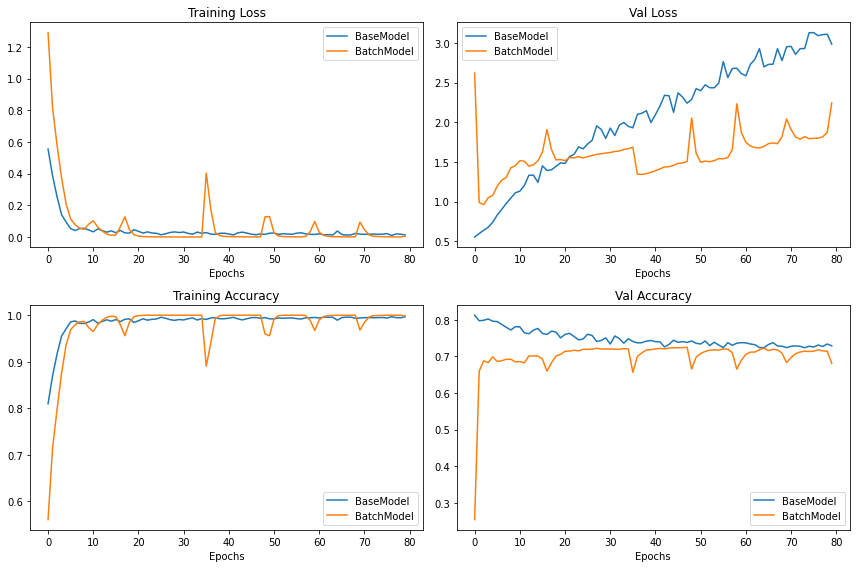

In [134]:
plot_loss_curves([history_base_model, history_batch_model])

### D. Build a new model Mdrop by adding dropout to your baseline model Mbase. Select a dropout rate p ∈ {0.1,0.2,0.3,0.4,0.5}, and set p amount of units to zero for each hidden layer. Train your model with the same parameters specified in (b) and save the best model.

1. What is the best dropout rate for your model measured by the overall prediction accuracy? Show your work.
2. Plot the learning curves of Mbase and Mbatch and Mdrop in one graph.
3. Fill in Row #3 in Table 1

In [135]:
def Dropout_model(drop_rate, model_name):
    drop_model = tf.keras.models.Sequential([
                    tf.keras.layers.Input((32, 32,3)),
                    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
                    tf.keras.layers.Dropout(drop_rate),
                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
                    tf.keras.layers.Dropout(drop_rate),
                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                    tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
                    tf.keras.layers.Dropout(drop_rate),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(500, activation="relu"),
                    tf.keras.layers.Dropout(drop_rate),
                    tf.keras.layers.Dense(10, activation="softmax")], name=model_name)
    return drop_model

In [136]:
# 0.1
dropout_rate = 0.1
drop_model_1 = Dropout_model(drop_rate=dropout_rate, model_name="Dropout1")
drop_model_1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])
# 0.2
dropout_rate = 0.2
drop_model_2 = Dropout_model(drop_rate=dropout_rate, model_name="Dropout2")
drop_model_2.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])
# 0.3
dropout_rate = 0.3
drop_model_3 = Dropout_model(drop_rate=dropout_rate, model_name="Dropout3")
drop_model_3.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])
# 0.4
dropout_rate = 0.4
drop_model_4 = Dropout_model(drop_rate=dropout_rate, model_name="Dropout4")
drop_model_4.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])
# 0.5
dropout_rate = 0.5
drop_model_5 = Dropout_model(drop_rate=dropout_rate, model_name="Dropout5")
drop_model_5.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

In [137]:
ModelCheckpoint_path = "Q1_drop1_model_checkpoint.hdf5"
model_checkpoint_drop1 = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path, monitor=monitor, save_weights_only=True, save_best_only=True)
ModelCheckpoint_path = "Q1_drop2_model_checkpoint.hdf5"
model_checkpoint_drop2 = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path, monitor=monitor, save_weights_only=True, save_best_only=True)
ModelCheckpoint_path = "Q1_drop3_model_checkpoint.hdf5"
model_checkpoint_drop3 = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path, monitor=monitor, save_weights_only=True, save_best_only=True)
ModelCheckpoint_path = "Q1_drop4_model_checkpoint.hdf5"
model_checkpoint_drop4 = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path, monitor=monitor, save_weights_only=True, save_best_only=True)
ModelCheckpoint_path = "Q1_drop5_model_checkpoint.hdf5"
model_checkpoint_drop5 = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path, monitor=monitor, save_weights_only=True, save_best_only=True)


history_drop1_model = drop_model_1.fit(x=X_train, y=y_train, epochs=80, batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint_drop1], verbose=0)
history_drop2_model = drop_model_2.fit(x=X_train, y=y_train, epochs=80, batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint_drop2], verbose=0)
history_drop3_model = drop_model_3.fit(x=X_train, y=y_train, epochs=80, batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint_drop3], verbose=0)
history_drop4_model = drop_model_4.fit(x=X_train, y=y_train, epochs=80, batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint_drop4], verbose=0)
history_drop5_model = drop_model_5.fit(x=X_train, y=y_train, epochs=80, batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint_drop5], verbose=0)                                    

In [138]:
drop_model_1.load_weights("Q1_drop1_model_checkpoint.hdf5")
drop_model_2.load_weights("Q1_drop2_model_checkpoint.hdf5")
drop_model_3.load_weights("Q1_drop3_model_checkpoint.hdf5")
drop_model_4.load_weights("Q1_drop4_model_checkpoint.hdf5")
drop_model_5.load_weights("Q1_drop5_model_checkpoint.hdf5")

In [139]:
drop_models = {}
drop_models["10%"] = drop_model_1.evaluate(X_valid, y_valid, verbose=0)
drop_models["20%"] = drop_model_2.evaluate(X_valid, y_valid, verbose=0)
drop_models["30%"] = drop_model_3.evaluate(X_valid, y_valid, verbose=0)
drop_models["40%"] = drop_model_4.evaluate(X_valid, y_valid, verbose=0)
drop_models["50%"] = drop_model_5.evaluate(X_valid, y_valid, verbose=0)

In [140]:
print(pd.DataFrame(drop_models, index=["Loss", "Acc"]).T.sort_values(by="Loss"))

         Loss       Acc
30%  0.789995  0.729062
20%  0.806698  0.722396
40%  0.824182  0.720833
10%  0.837428  0.710833
50%  1.030996  0.653021


In [141]:
dropout_rate = 0.3
drop_model = Dropout_model(drop_rate=dropout_rate, model_name="Dropout3")
drop_model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

ModelCheckpoint_path = "Q1_drop_model_checkpoint.hdf5"
# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path,
                                                      monitor=monitor,
                                                      save_weights_only=True,
                                                      save_best_only=True)
start = time()
history_drop_model = drop_model.fit(x=X_train, y=y_train,
                                    epochs=80,
                                    batch_size=128,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[model_checkpoint], verbose=0)
drop_model_time = time()-start

In [142]:
drop_model.load_weights(ModelCheckpoint_path) #load best model weights
training_performance = drop_model.evaluate(X_train, np.squeeze(y_train), verbose=0)
validation_performance = drop_model.evaluate(X_valid, np.squeeze(y_valid), verbose=0)
print(performance_table(training_performance, validation_performance))

          Training  Validation
Loss      0.166212    0.799910
Accuracy  0.975469    0.733229


In [143]:
test_predictions = drop_model.predict(X_test, verbose=0)
print(pd.DataFrame(accuracy_per_class(np.squeeze(y_test), test_predictions)))

   Class  Accuracy
0      0  0.951000
1      1  0.970167
2      2  0.924500
3      3  0.913917
4      4  0.929500
5      5  0.926417
6      6  0.960750
7      7  0.957750
8      8  0.972250
9      9  0.962083


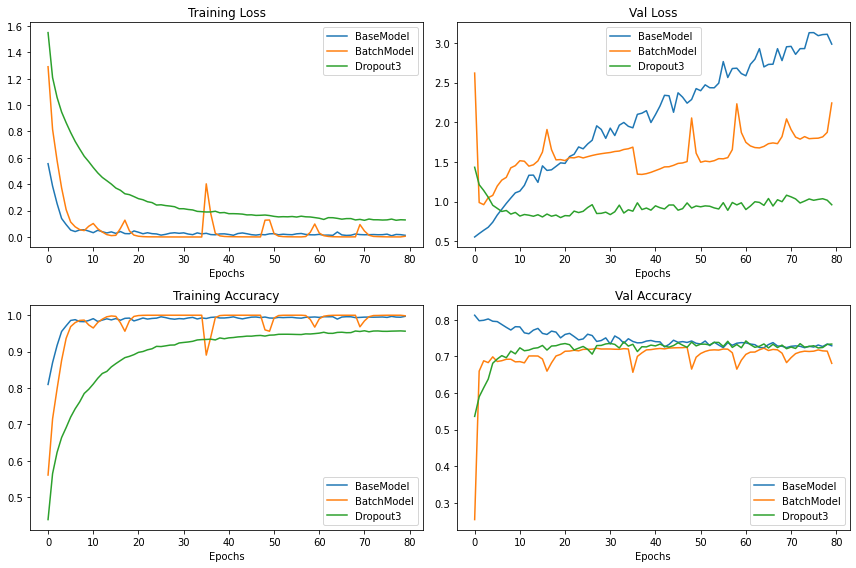

In [144]:
plot_loss_curves([history_base_model, history_batch_model, history_drop_model])

### E. Build a new model Mfinal by integrating both batch normalization and the best dropout rate to your baseline model Mbase. Train your model with the same parameters specified in (b) and save the best model.

In [145]:
drop_rate = 0.3
final_model = tf.keras.models.Sequential([
                tf.keras.layers.Input((32, 32,3)),
                tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
                tf.keras.layers.Dropout(drop_rate),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
                tf.keras.layers.Dropout(drop_rate),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(1,1), padding="same", activation="relu"),
                tf.keras.layers.Dropout(drop_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation="relu"),
                tf.keras.layers.Dropout(drop_rate),
                tf.keras.layers.Dense(10, activation="softmax")], name="MFinal")
# Compile our CNN
final_model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
ModelCheckpoint_path = "Q1_final_model_checkpoint.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ModelCheckpoint_path, monitor=monitor, save_weights_only=True, save_best_only=True)

start = time()
history_final = final_model.fit(x=X_train, y=y_train,
                                epochs=80,
                                batch_size=128,
                                validation_data=(X_valid, y_valid),
                                callbacks=[model_checkpoint], verbose=0)
final_model_time = time()-start

In [146]:
final_model.load_weights(ModelCheckpoint_path) #load best model weights
training_performance = final_model.evaluate(X_train, np.squeeze(y_train), verbose=0)
validation_performance = final_model.evaluate(X_valid, np.squeeze(y_valid), verbose=0)
print(performance_table(training_performance, validation_performance))

          Training  Validation
Loss      0.647249    1.277171
Accuracy  0.779167    0.644479


In [147]:
test_predictions = final_model.predict(X_test, verbose=0)
print(pd.DataFrame(accuracy_per_class(np.squeeze(y_test), test_predictions)))

   Class  Accuracy
0      0  0.942333
1      1  0.960667
2      2  0.917917
3      3  0.905000
4      4  0.851917
5      5  0.921500
6      6  0.915417
7      7  0.949583
8      8  0.958833
9      9  0.955167


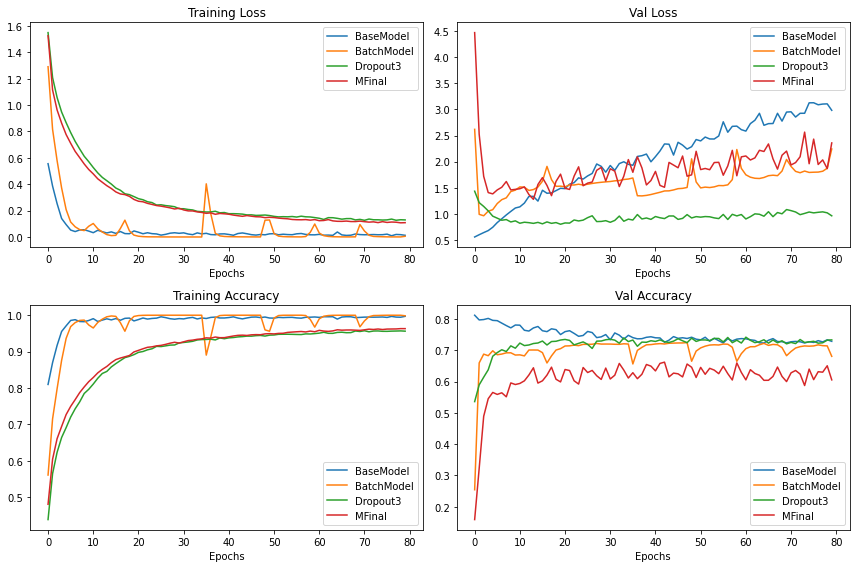

In [148]:
plot_loss_curves([history_base_model, history_batch_model, history_drop_model, history_final])

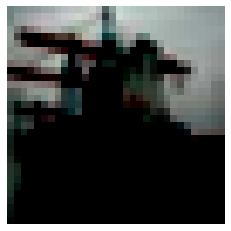

In [149]:
# Showing sample image
plt.imshow(X_train[1200])
plt.axis(False);

In [150]:
# For Kaggle Submission - Best model so far
test_predictions = tf.argmax(drop_model.predict(X_test, verbose=0), axis=1)
FernandoSubmission = pd.DataFrame({'id':range(1,len(test_predictions)+1), 'class':test_predictions})
FernandoSubmission.to_csv('kaggle_submission.csv', index=False)

In [151]:
base_model_time


117.47864890098572

In [152]:
batch_model_time

130.27614426612854

In [153]:
drop_model_time

115.15521764755249

In [154]:
final_model_time

108.7685616016388